# Signal-to-Noise Test

### Motivation

In this notebook we will look at how the Zernike polynomial estimation performance from the Wavefront Estimation Calculation changes as a function of the magnitude of the test star with the background noise level held constant. 

### Performance Metric
Our performance metric in this first version will be the RMS value between OPD results and the Zernike polynomials given by `ts_wep` output.

### Test Data
The test data was created on the UW *epyc* machine using `runSnrAnalysis.py` in the `ts_phosim/notebooks/analysis_scripts` directory.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
%matplotlib inline

In [4]:
data_dir = '/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_data/signal_to_noise_test/150x150yOffset/'

In [5]:
calcMagMetrics = calcMetrics()

### Calc SNR

Our first task is to calculate the signal-to-noise value of the donut pixels as a function of magnitude and setting phosim to generate a `quick_background`. We will then compare our g-band 10 sigma SNR value to values calculated using a notebook from Bo Xin found here: https://github.com/bxin/scratchBook/blob/master/saturation_limit/saturation_limit_donut.ipynb

In [6]:
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits

In [7]:
def measureSNR(im_file, star_file):
    
    """
    Calculate the signal-to-noise ratio in a Phosim amplifier image.
    
    Input
    -----
    im_file: string
        Filename for PostISR CCD phosim image with donuts
    
    star_file: string
        Filename for location of star catalog used to create PhoSim image
        
    Returns
    -------
    snr: float
        Pixel level SNR value of donut image
        
    bg_val: float
        Measured background sky counts
        
    signal: float
        Measured signal counts
    """
    
    star_cat = np.genfromtxt(star_file)
    hdulist = fits.open(im_file)
    
    w = WCS(hdulist[1].header)
    x, y = w.wcs_world2pix(np.array(star_cat[:, 1])*u.deg, np.array(star_cat[:, 2])*u.deg, 1)
    borders = np.array([[y[0] - 120, y[0] + 120], [y[0] - 120, y[0] + 120]], dtype=int)
    donut_array = hdulist[1].data[borders[1][0]:borders[1][1], borders[0][0]:borders[0][1]]
    
    x = 142 + 47*np.cos(np.arange(0, 2*np.pi, 0.05))
    y = 110 + 47*np.sin(np.arange(0, 2*np.pi, 0.05))

    bg = donut_array[:50, :50].flatten()
    bg_val = np.median(bg)
    
    val = []
    for xx, yy in zip(y, x):
        val.append(donut_array[int(xx), int(yy)] - bg_val)
        
    signal = np.median(val)
    snr = signal / np.sqrt(signal + (bg_val))
    
    return snr, bg_val, signal

In [8]:
mag_array = np.arange(11.5, 16.1, 0.5)
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
snr_array = []
bg_val_array = []
for mag in mag_array:
    
    image_dir = os.path.join(data_dir, 'mag_quickbg_%.2f_output/input/rerun/run1/postISRCCD/09006001-g/R22/' % mag)
    image_file = os.path.join(image_dir, 'postISRCCD_09006001-g-R22-S02-det092.fits')
    star_cat_file = '../analysis_scripts/starCat.txt'
    
    snr, bg_val, signal = measureSNR(image_file, star_cat_file)
    bg_val_array.append(bg_val)
    snr_array.append(snr)
    
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.quickBackgroundSNR.%.1f' % (mag))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.quickBackgroundSNR.%.1f' % (mag))
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)
zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

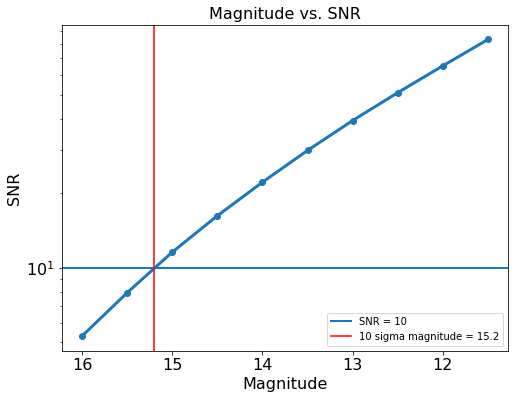

In [9]:
fig = plt.figure(figsize=(8,6))
plt.plot(mag_array, snr_array, '-o', lw=3)
plt.xlabel('Magnitude', size=16)
plt.ylabel('SNR', size=16)
plt.axhline(y=10., lw=2, label='SNR = 10')
plt.axvline(15.2, 0., 100., c='r', label='10 sigma magnitude = 15.2')
plt.legend()
plt.gca().invert_xaxis()
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Magnitude vs. SNR', size=16)
plt.yscale('log')

In [10]:
# What is the background in sky_counts
print(bg_val_array, np.mean(bg_val_array), np.mean(bg_val_array)/205.55)

[343.22687, 343.235, 343.2492, 343.18048, 344.922, 344.92938, 345.0015, 344.8231, 343.21326, 343.38208] 343.9163 1.6731514973641601


Our 10-sigma SNR g-band magnitude seems to be about 15.2 which is brighter than the 15.41 estimated in the notebook we are comparing against. But this appears to be due to the difference in dark sky between the project estimate and the phosim dark sky simulated using `quick_background`. If we normalize our background level to be the same as that from the notebook as we do in the cells below then we see that our 10-sigma magnitude matches that from the notebook so our simulated signal-to-noise levels are accurate in our phosim images. They just have a brighter background so the magnitudes don't match up. This means we can use these images to see how well the Zernikes are estimated as a function of signal-to-noise in the rest of the notebook.

In [11]:
def measureSNR(im_file, star_file):
    
    """
    Calculate the signal-to-noise ratio in a Phosim amplifier image.
    
    Input
    -----
    im_file: string
        Filename for PostISR CCD phosim image with donuts
    
    star_file: string
        Filename for location of star catalog used to create PhoSim image
        
    Returns
    -------
    snr: float
        Pixel level SNR value of donut image
        
    bg_val: float
        Measured background sky counts
        
    signal: float
        Measured signal counts
    """
    
    star_cat = np.genfromtxt(star_file)
    hdulist = fits.open(im_file)
    
    w = WCS(hdulist[1].header)
    x, y = w.wcs_world2pix(np.array(star_cat[:, 1])*u.deg, np.array(star_cat[:, 2])*u.deg, 1)
    borders = np.array([[y[0] - 120, y[0] + 120], [y[0] - 120, y[0] + 120]], dtype=int)
    donut_array = hdulist[1].data[borders[1][0]:borders[1][1], borders[0][0]:borders[0][1]]
    
    x = 142 + 47*np.cos(np.arange(0, 2*np.pi, 0.05))
    y = 110 + 47*np.sin(np.arange(0, 2*np.pi, 0.05))

    bg = donut_array[:50, :50].flatten()
    bg_val = np.median(bg)
    
    val = []
    for xx, yy in zip(y, x):
        val.append(donut_array[int(xx), int(yy)] - bg_val)
        
    signal = np.median(val)
    snr = signal / np.sqrt(signal + (bg_val/1.67))
    
    return snr, bg_val, signal

In [12]:
mag_array = np.arange(11.5, 16.1, 0.5)
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
snr_array = []
bg_val_array = []
for mag in mag_array:
    
    image_dir = os.path.join(data_dir, 'mag_quickbg_%.2f_output/input/rerun/run1/postISRCCD/09006001-g/R22/' % mag)
    image_file = os.path.join(image_dir, 'postISRCCD_09006001-g-R22-S02-det092.fits')
    star_cat_file = '../analysis_scripts/starCat.txt'
    
    snr, bg_val, signal = measureSNR(image_file, star_cat_file)
    bg_val_array.append(bg_val)
    snr_array.append(snr)
    
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.quickBackgroundSNR.%.1f' % (mag))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.quickBackgroundSNR.%.1f' % (mag))
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)
zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

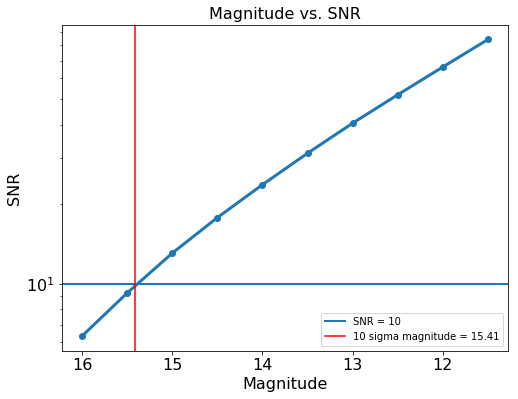

In [13]:
fig = plt.figure(figsize=(8,6))
plt.plot(mag_array, snr_array, '-o', lw=3)
plt.xlabel('Magnitude', size=16)
plt.ylabel('SNR', size=16)
plt.axhline(y=10., lw=2, label='SNR = 10')
plt.axvline(15.41, 0., 100., c='r', label='10 sigma magnitude = 15.41')
plt.legend()
plt.gca().invert_xaxis()
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Magnitude vs. SNR', size=16)
plt.yscale('log')

## Signal-to-Noise Test

Now that we are confident that our SNR values are correct from the PhoSim images we can compare the residuals between the OPD values for the Zernikes and the WFS estimated values to see how well we calculate the Zernikes using the WFS code at different SNR values and see if an SNR value of 10 is sufficient.

In [14]:
def measureSNR(im_file, star_file):
    
    """
    Calculate the signal-to-noise ratio in a Phosim amplifier image.
    
    Input
    -----
    im_file: string
        Filename for PostISR CCD phosim image with donuts
    
    star_file: string
        Filename for location of star catalog used to create PhoSim image
        
    Returns
    -------
    snr: float
        Pixel level SNR value of donut image
        
    bg_val: float
        Measured background sky counts
        
    signal: float
        Measured signal counts
    """
    
    star_cat = np.genfromtxt(star_file)
    hdulist = fits.open(im_file)
    
    w = WCS(hdulist[1].header)
    x, y = w.wcs_world2pix(np.array(star_cat[:, 1])*u.deg, np.array(star_cat[:, 2])*u.deg, 1)
    borders = np.array([[y[0] - 120, y[0] + 120], [y[0] - 120, y[0] + 120]], dtype=int)
    donut_array = hdulist[1].data[borders[1][0]:borders[1][1], borders[0][0]:borders[0][1]]
    
    x = 142 + 47*np.cos(np.arange(0, 2*np.pi, 0.05))
    y = 110 + 47*np.sin(np.arange(0, 2*np.pi, 0.05))

    bg = donut_array[:50, :50].flatten()
    bg_val = np.median(bg)
    
    val = []
    for xx, yy in zip(y, x):
        val.append(donut_array[int(xx), int(yy)] - bg_val)
        
    signal = np.median(val)
    snr = signal / np.sqrt(signal + (bg_val))
    
    return snr, bg_val, signal

In [15]:
mag_array = np.arange(11.5, 16.1, 0.5)
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
snr_array = []
bg_val_array = []
for mag in mag_array:
    
    image_dir = os.path.join(data_dir, 'mag_quickbg_%.2f_output/input/rerun/run1/postISRCCD/09006001-g/R22/' % mag)
    image_file = os.path.join(image_dir, 'postISRCCD_09006001-g-R22-S02-det092.fits')
    star_cat_file = '../analysis_scripts/starCat.txt'
    
    snr, bg_val, signal = measureSNR(image_file, star_cat_file)
    bg_val_array.append(bg_val)
    snr_array.append(snr)
    
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.quickBackgroundSNR.%.1f' % (mag))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.quickBackgroundSNR.%.1f' % (mag))
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)
zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

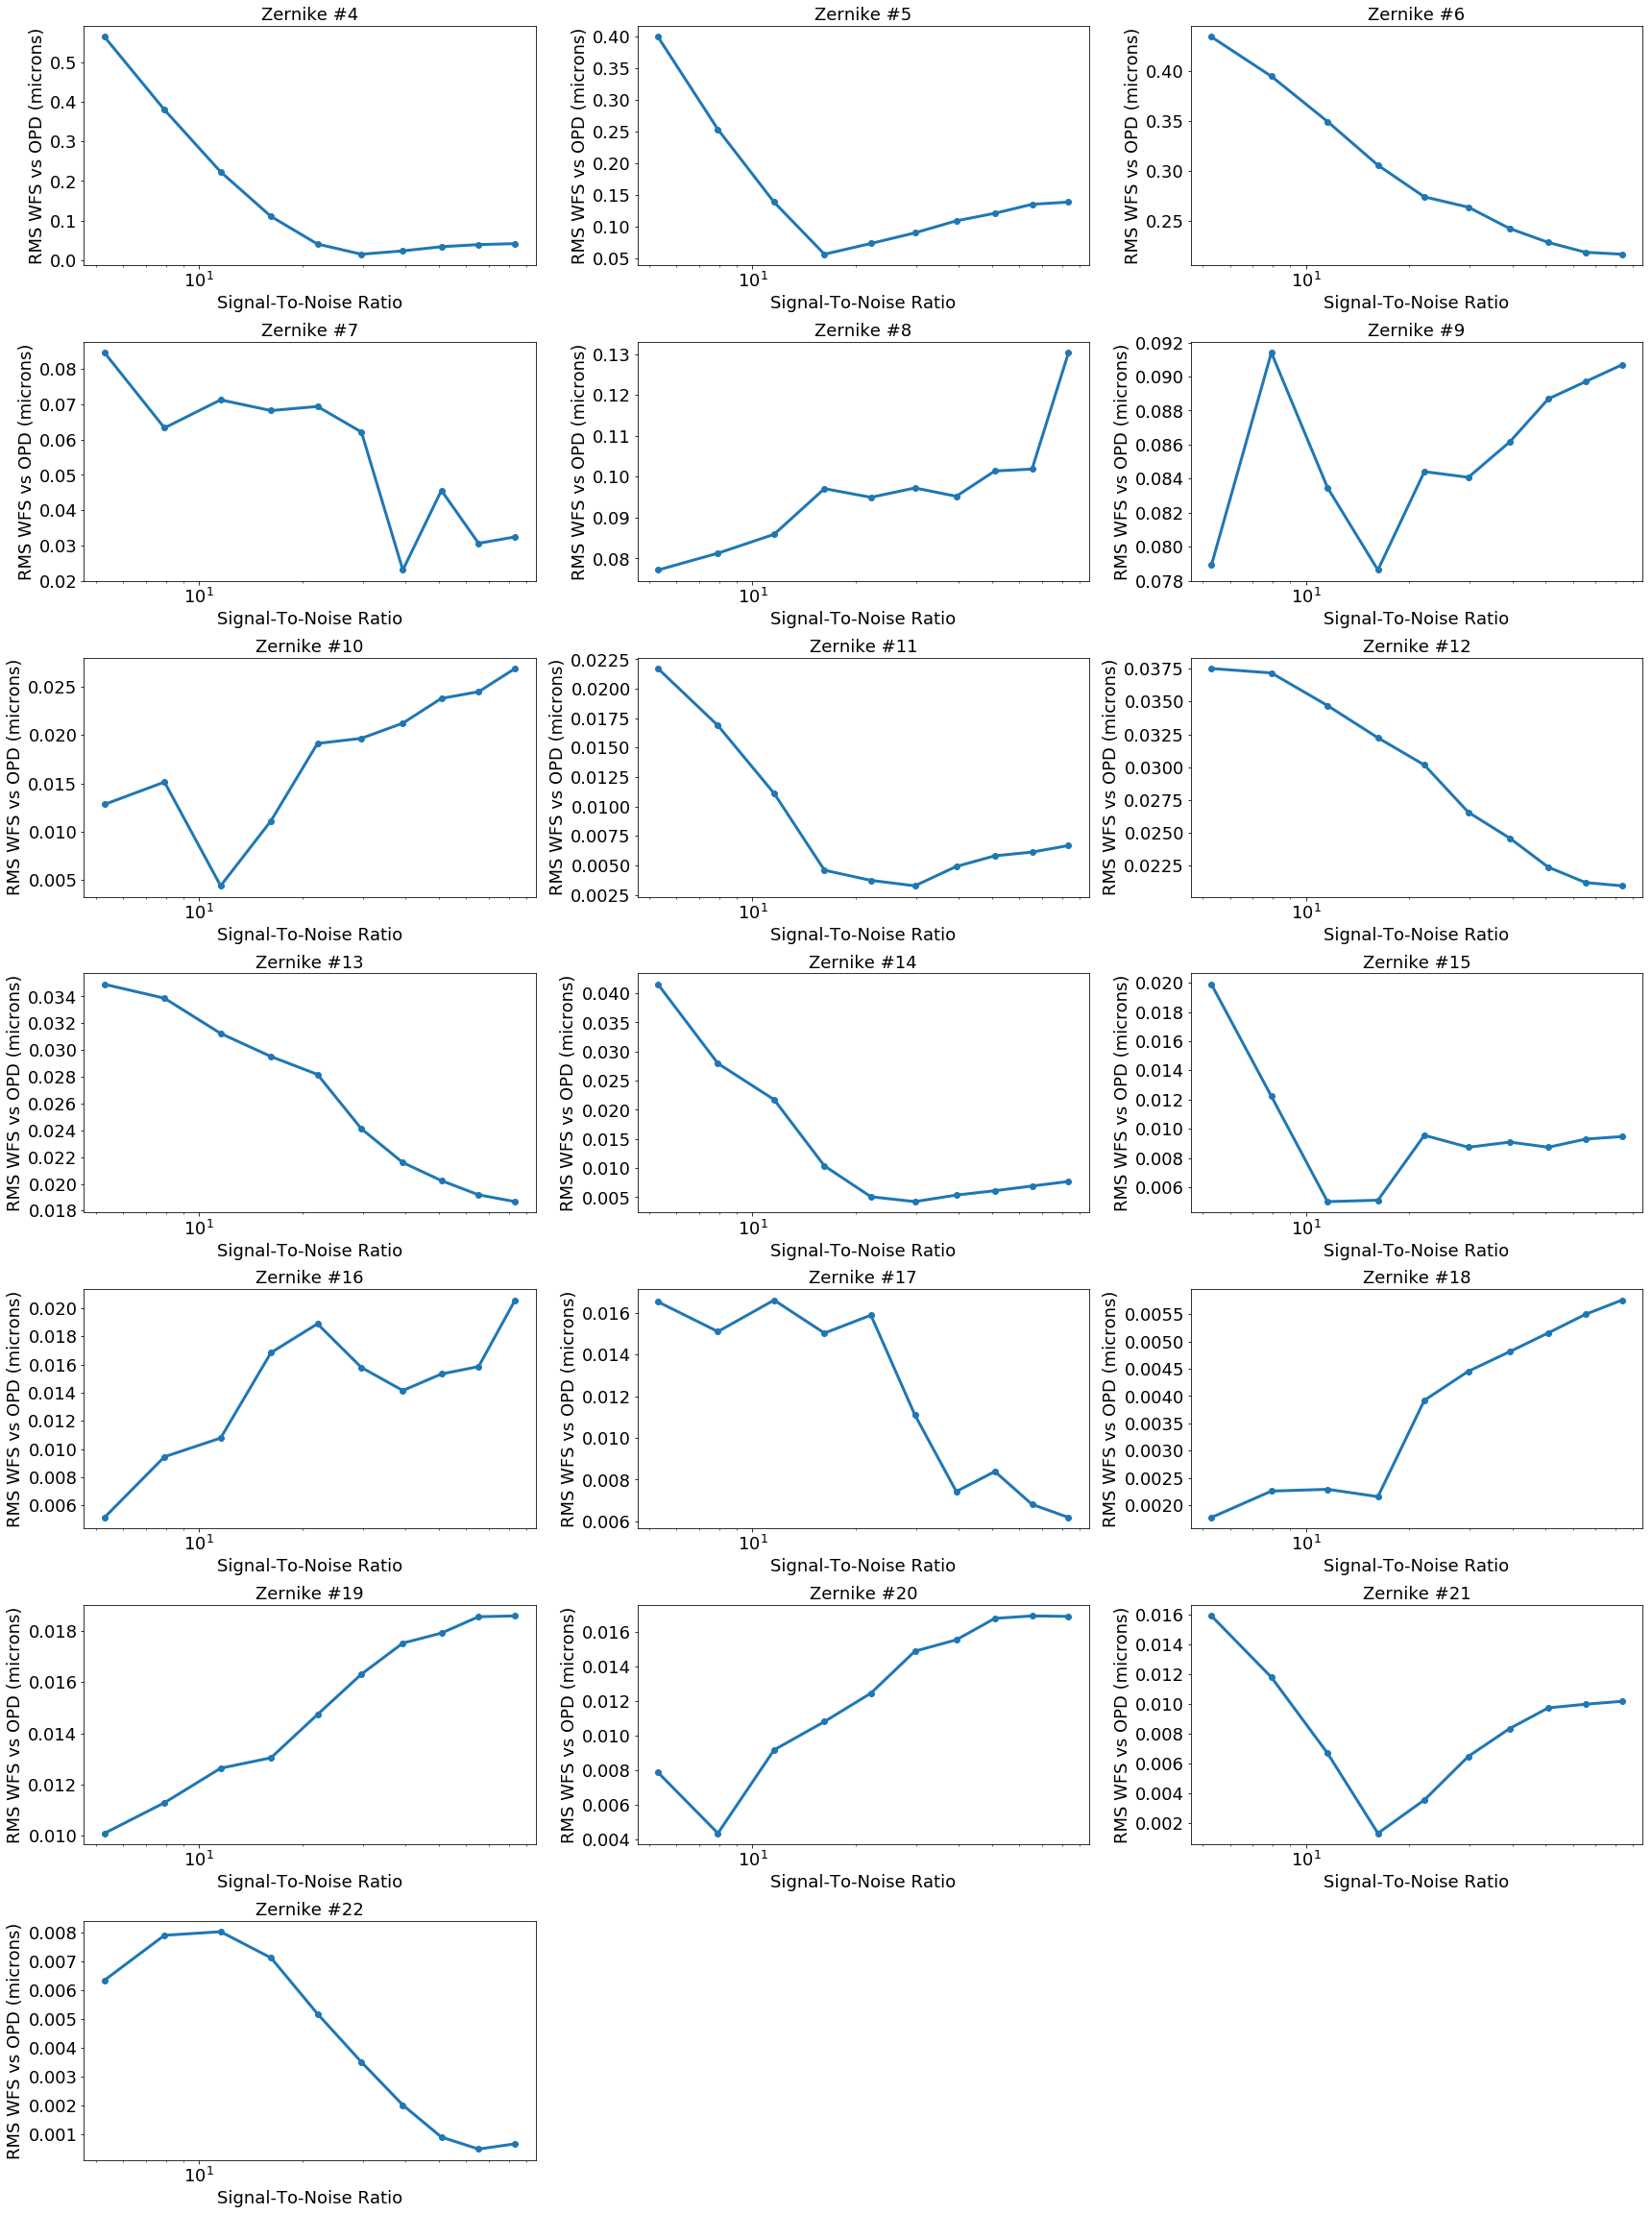

In [16]:
fig = plt.figure(figsize=(24,36))

plot_mag = False # If you'd rather plot magnitude than SNR set this to True

for zernike in range(19):
    fig.add_subplot(8, 3, zernike+1)
    if plot_mag is True:
        plt.plot(mag_array, np.sqrt(np.mean(np.square(zernikeErrors[zernike]), axis=0)), '-o', lw=3)
        plt.xlabel('Magnitude of Star', size=18)
    else:
        plt.plot(snr_array, np.sqrt(np.mean(np.square(zernikeErrors[zernike]), axis=0)), '-o', lw=3)
        plt.xlabel('Signal-To-Noise Ratio', size=18)
        plt.xscale('log')
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    #plt.legend(fontsize=16)
    plt.title('Zernike #%i' % (zernike+4), size=18)
    
plt.tight_layout()

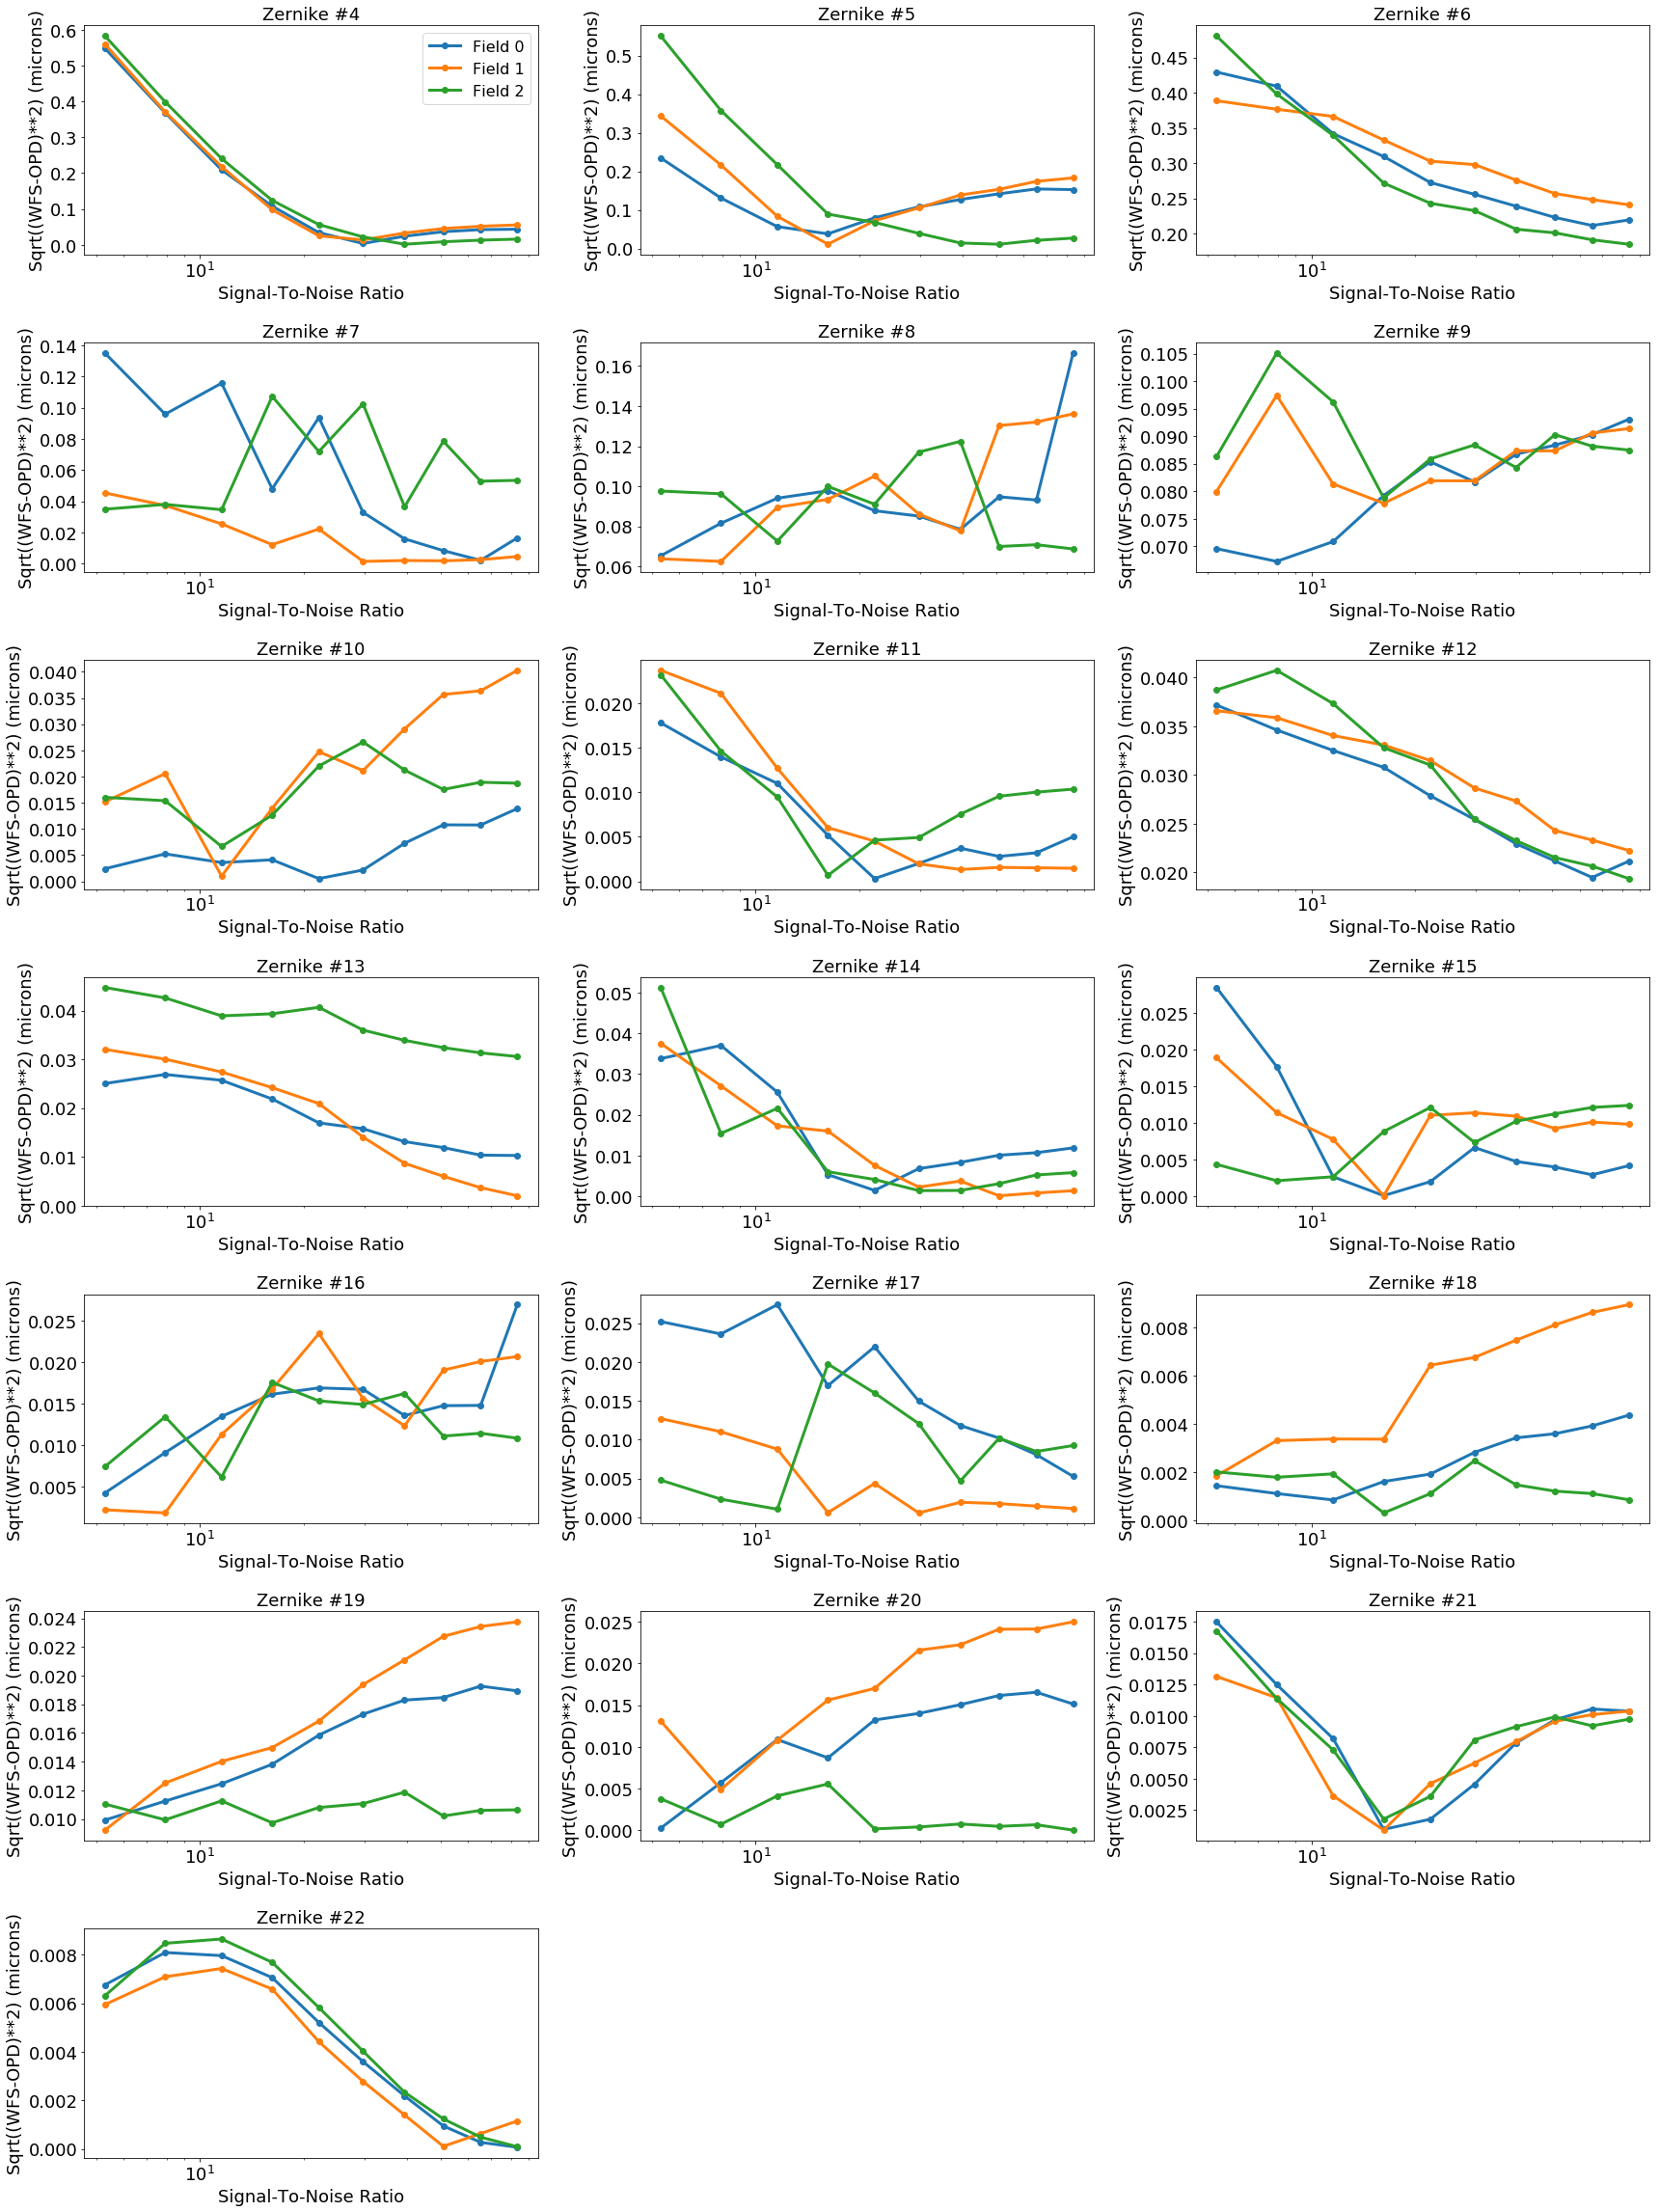

In [17]:
fig = plt.figure(figsize=(24,36))

plot_mag = False

for zernike in range(19):
    fig.add_subplot(8, 3, zernike+1)
    for ccd in range(3):
        if plot_mag is True:
            plt.plot(mag_array, zernikeErrors[zernike, ccd], '-o', lw=3, label='Field %i' % ccd)
        else:
            plt.plot(snr_array, zernikeErrors[zernike, ccd], '-o', lw=3, label='Field %i' % ccd)
    if plot_mag is True:
        plt.xlabel('Magnitude of Star', size=18)
    else:
        plt.xlabel('Signal-To-Noise Ratio', size=18)
        plt.xscale('log')
    plt.ylabel('Sqrt((WFS-OPD)**2) (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    if zernike == 0:
        plt.legend(fontsize=16)
    plt.title('Zernike #%i' % (zernike+4), size=18)
    
plt.tight_layout()

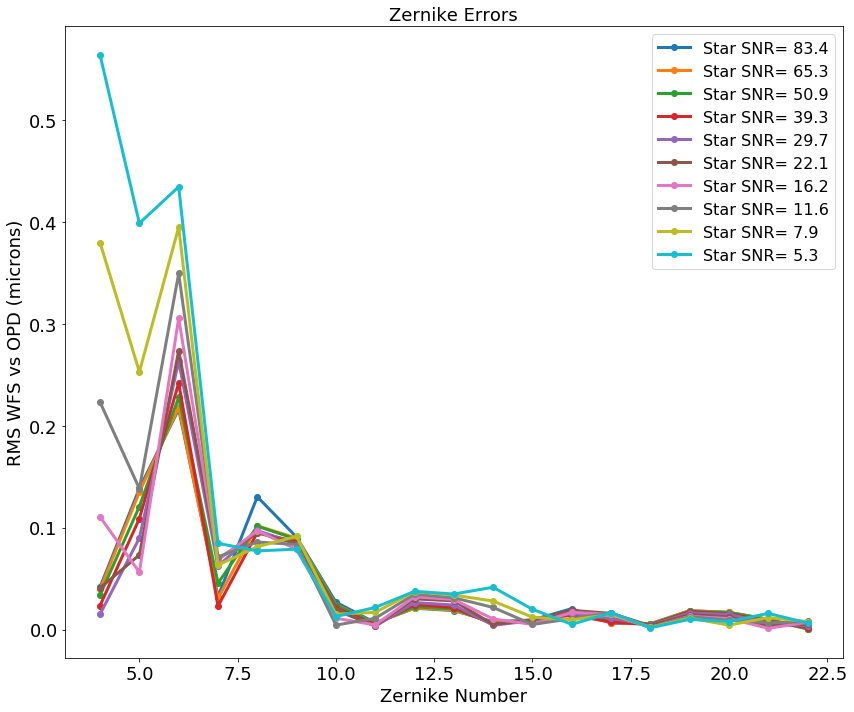

In [18]:
fig = plt.figure(figsize=(12,10))

plot_mag = False

for i in range(len(snr_array)):
    if plot_mag is True:
        plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', lw=3, label='Star Mag= %.1f' % mag_array[i])
    else:
        plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', lw=3, label='Star SNR= %.1f' % snr_array[i])
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors', size=18)
    
plt.tight_layout()

### SNR > 20 Needed?

If we color code results with a signal-to-noise ratio of greater than 20.0 (g-band magnitude <~ 14.1) as blue and those less than 20 as red we see that the results are very similar for SNR > 20 except for Zernike Polynomials 7 & 8. The current lowest magnitude for g-band is set to 16.17. Should this be set higher (somewhere between 14. and 14.5)?

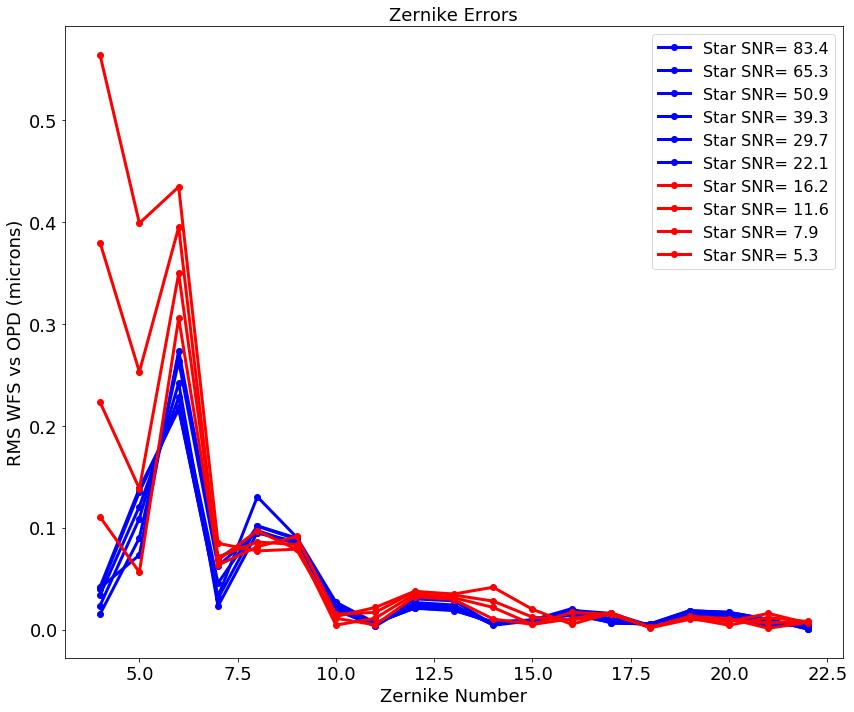

In [20]:
fig = plt.figure(figsize=(12,10))

plot_mag = False

for i in range(len(snr_array)):
    if plot_mag is True:
        if snr_array[i] < 20.0:
            plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', c='r', 
                     lw=3, label='Star Mag= %.1f' % mag_array[i])
        else:
            plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', c='b', 
                     lw=3, label='Star Mag= %.1f' % mag_array[i])
    else:
        if snr_array[i] < 20.0:
            plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', c='r',
                     lw=3, label='Star SNR= %.1f' % snr_array[i])
        else:
            plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', c='b',
                     lw=3, label='Star SNR= %.1f' % snr_array[i])
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors', size=18)
    
plt.tight_layout()

#### Generate CCD map of error values

In [21]:
starCat = np.genfromtxt(os.path.join(data_dir, 'starCat.txt'), names=['field', 'ra', 'dec', 'mag'])

In [22]:
starCat['ra'][:3] = starCat['ra'][:3] - 360.

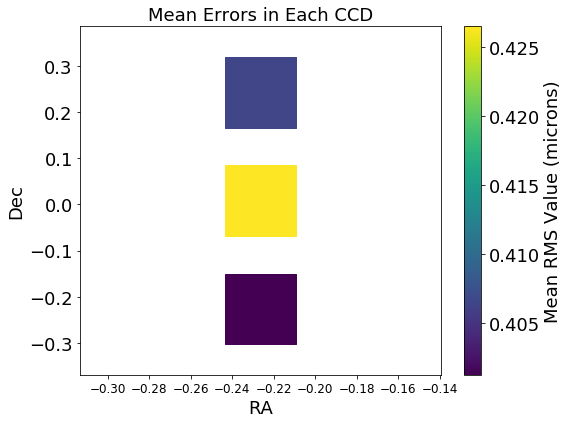

In [23]:
fig = plt.figure(figsize=(8,6))
plt.scatter(starCat['ra'], starCat['dec'], c=np.mean(np.sqrt(np.array(ssrFieldVals)), axis=0), s=5000, marker='s')
plt.xlabel('RA', size=18)
plt.ylabel('Dec', size=18)
plt.xticks(size=12)
plt.yticks(size=18)
cbar = plt.colorbar()
cbar.set_label('Mean RMS Value (microns)', size=18)
cbar.ax.tick_params(labelsize=18)
plt.title('Mean Errors in Each CCD', size=18)
plt.tight_layout()